In [ ]:
!pip install tensorflow==2.3.0
!pip install tf-keras-vis tensorflow

In [ ]:
!pip install quickdraw

In [ ]:
# get owl data

from quickdraw import QuickDrawData
from quickdraw import QuickDrawDataGroup

num_owls_train = 500
num_owls_test = 200
num_owls_valid = 50

num_fish_train = 500
num_fish_test = 200
num_fish_valid = 50

owls = QuickDrawDataGroup("owl")
for i in range(num_owls_train):
    owls.get_drawing().image.save("./data/images/train/owl/owl" + str(i) + ".png")
for i in range(num_owls_test):
    owls.get_drawing().image.save("./data/images/test/owl/owl" + str(i) + ".png")
for i in range(num_owls_valid):
    owls.get_drawing().image.save("./data/images/valid/owl/owl" + str(i) + ".png")

fish = QuickDrawDataGroup("fish")
for i in range(num_fish_train):
    fish.get_drawing().image.save("./data/images/train/fish/fish" + str(i) + ".png")
for i in range(num_fish_test):
    fish.get_drawing().image.save("./data/images/test/fish/fish" + str(i) + ".png")
for i in range(num_fish_valid):
    fish.get_drawing().image.save("./data/images/valid/fish/fish" + str(i) + ".png")

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

C:\Users\rodam\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rodam\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\rodam\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Tensorflow recognized 0 GPUs


In [19]:
# Parsing in imagenet class data

imagelabels = open("./data/imagenetlabels.txt", "r")
netlabels1 = imagelabels.readlines()
netlabels = dict()
wordlabels = []
count = 0
for line in netlabels1:
    if "{" in line:
        line = line.replace("{", "")
    elif "}" in line:
        line = line.replace("}", "")
    if "'" in line:
        line = line.replace("'", "")
    line = line.strip()
    if count != 999:
        line = line[:-1]
    result = ''.join([i for i in line if not i.isdigit()])[2:]
    netlabels[count] = result
    count += 1
    for word in result.split(", "):
        wordlabels.append(word)
        break
print()
netlabels

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [3]:
# Importing pretrained vgg16 with imagenet weights

from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', input_shape = (224, 224, 3), include_top = False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
model.trainable = False

In [5]:
import tensorflow.keras as keras

inputs = keras.Input(shape=(224, 224, 3))

x = model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
new_model = keras.Model(inputs, outputs)

In [38]:
new_model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = "./data/images/train"
valid_path = "./data/images/valid"

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(train_path, target_size=(224, 224), classes=wordlabels, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(valid_path, target_size=(224, 224), classes=wordlabels, batch_size=10)

Found 1000 images belonging to 1000 classes.
Found 100 images belonging to 1000 classes.


In [33]:
test_path = "./data/images/test/pictures"
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224, 224), classes=wordlabels, batch_size=10)

Found 40 images belonging to 1000 classes.


In [24]:
assert train_batches.n == num_owls_train + num_fish_train
assert valid_batches.n == num_owls_valid + num_fish_valid

NameError: name 'num_owls_train' is not defined

In [34]:
imgs, labels = next(train_batches)

In [35]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

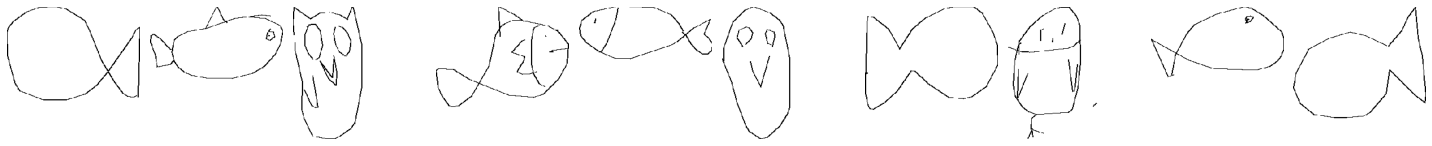

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [36]:
plot_images(imgs)
print(labels)

In [39]:
new_model.fit(x=train_batches, validation_data=valid_batches, epochs=5)

Epoch 1/5
100/100 [==============================] - 67s 669ms/step - loss: 1.1921e-07 - accuracy: 0.9990 - val_loss: 1.1921e-07 - val_accuracy: 0.9990
Epoch 2/5
100/100 [==============================] - 66s 664ms/step - loss: 1.1921e-07 - accuracy: 0.9990 - val_loss: 1.1921e-07 - val_accuracy: 0.9990
Epoch 3/5
100/100 [==============================] - 65s 654ms/step - loss: 1.1921e-07 - accuracy: 0.9990 - val_loss: 1.1921e-07 - val_accuracy: 0.9990
Epoch 4/5
100/100 [==============================] - 64s 639ms/step - loss: 1.1921e-07 - accuracy: 0.9990 - val_loss: 1.1921e-07 - val_accuracy: 0.9990
Epoch 5/5
100/100 [==============================] - 64s 639ms/step - loss: 1.1921e-07 - accuracy: 0.9990 - val_loss: 1.1921e-07 - val_accuracy: 0.9990


In [40]:
model.trainable = True

new_model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss="categorical_crossentropy",
              metrics=['accuracy'])


new_model.fit(x=train_batches, epochs=5, validation_data=valid_batches)

Epoch 1/5
100/100 [==============================] - 313s 3s/step - loss: 1.1921e-07 - accuracy: 0.9990 - val_loss: 1.1921e-07 - val_accuracy: 0.9990
Epoch 2/5
100/100 [==============================] - 303s 3s/step - loss: 1.1921e-07 - accuracy: 0.9990 - val_loss: 1.1921e-07 - val_accuracy: 0.9990
Epoch 3/5
100/100 [==============================] - 314s 3s/step - loss: 1.1921e-07 - accuracy: 0.9990 - val_loss: 1.1921e-07 - val_accuracy: 0.9990
Epoch 4/5
100/100 [==============================] - 291s 3s/step - loss: 1.1921e-07 - accuracy: 0.9990 - val_loss: 1.1921e-07 - val_accuracy: 0.9990
Epoch 5/5
100/100 [==============================] - 337s 3s/step - loss: 1.1921e-07 - accuracy: 0.9990 - val_loss: 1.1921e-07 - val_accuracy: 0.9990


In [41]:
new_model.history.history

{'loss': [1.1920928955078125e-07,
  1.1920928955078125e-07,
  1.1920928955078125e-07,
  1.1920928955078125e-07,
  1.1920928955078125e-07],
 'accuracy': [0.9989987015724182,
  0.9989987015724182,
  0.9989987015724182,
  0.9989987015724182,
  0.9989987015724182],
 'val_loss': [1.1920928955078125e-07,
  1.1920928955078125e-07,
  1.1920928955078125e-07,
  1.1920928955078125e-07,
  1.1920928955078125e-07],
 'val_accuracy': [0.9989980459213257,
  0.9989980459213257,
  0.9989980459213257,
  0.9989980459213257,
  0.9989980459213257]}

In [42]:
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [44]:
import os
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

# Load images and convert to numpy array
images = []
cols = 5
rows = 8

for root, dirs, files in os.walk("./data/images/test/pictures", topdown=False):
    for name in files:
        images.append(load_img(os.path.join(root, name), target_size=(224, 224)))

nparrays = []
for img in images:
    nparrays.append(np.array(img))

images = np.asarray(nparrays)

# Prep for input into VGG16
X = preprocess_input(images)

In [45]:
predictions = new_model.predict(test_batches)
print(predictions)

[[ -5.626794  ]
 [  0.7541249 ]
 [  1.7233119 ]
 [-14.617894  ]
 [  8.829981  ]
 [ -6.690597  ]
 [ -1.5313399 ]
 [  0.57612824]
 [ -3.52995   ]
 [  2.0032647 ]
 [-10.532102  ]
 [  0.8944471 ]
 [  6.1833525 ]
 [  2.28171   ]
 [  7.1506505 ]
 [ -4.933727  ]
 [  7.944298  ]
 [  9.866484  ]
 [-12.964961  ]
 [ -7.2645774 ]
 [  5.3438025 ]
 [ -3.7328136 ]
 [ -5.348093  ]
 [  5.776573  ]
 [-18.631071  ]
 [-17.340342  ]
 [ -6.285831  ]
 [ -0.612715  ]
 [ -9.72005   ]
 [ -1.8514302 ]
 [ -6.8594165 ]
 [ -7.3618035 ]
 [  6.14147   ]
 [ -4.5692353 ]
 [ -5.436031  ]
 [  4.847692  ]
 [  7.898977  ]
 [ -1.3199127 ]
 [ 11.845579  ]
 [  5.404717  ]]


In [50]:
# Model predictions and accuracy

from tensorflow.keras.applications.vgg16 import decode_predictions
predictions = new_model.predict(images)
labels = decode_predictions(predictions)

# 2d array of the top five predictions for each image
all_labels = []
all_accuracies = []

# array of the top prediction for each image
true_labels = []
true_accuracies = []

for i in range(len(labels)):
    
    # top prediction information
    name = labels[i][0][1]
    if "_" in name:
        name = name.replace("_", " ")
    true_labels.append(name)
    true_accuracies.append(round(float(labels[i][0][2])*100.0, 2))
    
    # all prediction information
    names = []
    accuracies = []
    for j in range(len(labels[i])):
        name = labels[i][j][1]
        if "_" in name:
            name = name.replace("_", " ")
        names.append(name)
        accuracies.append(round(float(labels[i][j][2])*100.0, 2))
    all_labels.append(names)
    all_accuracies.append(accuracies)


classes = []
for label in true_labels:
    for key, value in netlabels.items():
        if label in value:
            classes.append(int(key))
            break

print(classes)

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (40, 1)

In [ ]:
# information for each picture

for i in range(len(labels)):
    print("\033[1m" + "Information for picture {}".format(i+1) + "\033[0m")
    print("Top prediction: {}".format(true_labels[i]))
    print("Accuracy: {}%".format(str(true_accuracies[i])))
    print()
    print("All predictions: {}".format(str(all_labels[i])))
    print("All accuracies: {}".format(str(all_accuracies[i])))
    print()

In [ ]:
# Rendering
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
count = 0
dim2 = 0
for i, title in enumerate(true_labels):
    ax[dim2][count].set_title(str(i+1) + ". " + title, fontsize=16)
    ax[dim2][count].imshow(images[i])
    ax[dim2][count].axis('off')
    count += 1
    if count == cols:
        dim2 += 1
        count = 0
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Alternative replacement function
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# Imagenet indices
score = CategoricalScore(classes)

In [ ]:
# Vanilla Saliency

#%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
count = 0
dim2 = 0
for i, title in enumerate(true_labels):
    ax[dim2][count].set_title(title, fontsize=16)
    ax[dim2][count].imshow(saliency_map[i], cmap='jet')
    ax[dim2][count].axis('off')
    count += 1
    if count == cols:
        dim2 += 1
        count = 0
plt.tight_layout()
plt.show()

In [ ]:
# SmoothGrad

#%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
count = 0
dim2 = 0
for i, title in enumerate(true_labels):
    ax[dim2][count].set_title(title, fontsize=14)
    ax[dim2][count].imshow(saliency_map[i], cmap='jet')
    ax[dim2][count].axis('off')
    count += 1
    if count == cols:
        dim2 += 1
        count = 0
plt.tight_layout()
plt.savefig('data/saliency maps/smoothgrad.png')
plt.show()

In [ ]:
# GradCam++

#%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from matplotlib import cm

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
count = 0
dim2 = 0
for i, title in enumerate(true_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[dim2][count].set_title(title, fontsize=16)
    ax[dim2][count].imshow(images[i])
    ax[dim2][count].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[dim2][count].axis('off')
    count += 1
    if count == cols:
        dim2 += 1
        count = 0
plt.tight_layout()
plt.savefig('data/saliency maps/gradcam_plus_plus.png')
plt.show()

In [ ]:
# Faster-ScoreCAM

#%%time

from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
count = 0
dim2 = 0
for i, title in enumerate(true_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[dim2][count].set_title(title, fontsize=16)
    ax[dim2][count].imshow(images[i])
    ax[dim2][count].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[dim2][count].axis('off')
    count += 1
    if count == cols:
        dim2 += 1
        count = 0
plt.tight_layout()
plt.show()